In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from matplotlib import cm
from PIL import Image

import h5py
import glob

In [2]:
DATA_ROOT = "."#"../data/out/tmp"

In [3]:
def preprocess_image(img: npt.NDArray[np.float32]) -> npt.NDArray[np.uint8]:
    """
    Preprocesses an image by converting it to a 3-channel uint8 array.

    Parameters
    ----------
    img : numpy.typing.NDArray[np.float32]
        The input image array.

    Returns
    -------
    numpy.typing.NDArray[np.uint8]
        The preprocessed image array.
    """

    num_channels = img.shape[0]

    if num_channels == 1:
        img_2d = (np.squeeze(img, axis=0) * 255).astype(np.uint8)
        img = np.stack([img_2d] * 3, axis=0)
    return (np.transpose(img, axes=(1, 2, 0)) * 255).astype(np.uint8)

In [4]:
def plot_image(
    img: npt.NDArray[np.float32],
    ax = None,
    force_gray_scale: bool = False,
    **kwargs
) -> None:
    """
    Plot an image on the given axes.

    Parameters
    ----------
    img : numpy.ndarray
        The image to be plotted.
    ax : matplotlib.axes.Axes, optional
        The axes on which to plot the image. If not provided, the current axes will be used.

    Returns
    -------
    None
    """
    ax = ax or plt.gca()
    ax.imshow(
        Image.fromarray(preprocess_image(img)).convert(
            "L" if force_gray_scale else None
        ),
        **kwargs
    )
    ax.axis("off")

In [9]:
glob.glob(os.path.join(DATA_ROOT, "*.hy"))

['.\\830453_slots_0_0.hy', '.\\830453_slots_0_1.hy', '.\\830453_slots_0_2.hy']

In [49]:
def show_predictions_during_training(
    data_root,
    img_num: int,
    batch_num: int,
    epochs,#: list[int] | None,
    job_ids,#: list[int] | None,
    force_gray_scale: bool = False,
    img_kwargs: dict = {},
):
    """
    Display the original and predicted images during training for different epochs.

    Parameters
    ----------
    data_root : str
        The root directory of the data with predictions.
    img_num : int
        The index of the image to display.
    batch_num : int
        The index of the batch to display.
    epochs : list[int] | None, optional
        The list of epochs to display. If None, all available epochs will be displayed.

    Returns
    -------
    None
    """

    if epochs is None:
        epochs = [
            int(os.path.basename(file_nm).split("_")[-1].removesuffix(".hy"))
            for file_nm in glob.glob(os.path.join(data_root, "*.hy"))
        ]
    epochs.sort()
    if job_ids is None:
        job_ids = [
            int(os.path.basename(file_nm).split("_")[0])
            for file_nm in glob.glob(os.path.join(data_root, "*.hy"))
        ]
        job_ids = set(job_ids)
    fig, axes = plt.subplots(1, 1 + len(epochs), figsize=(10, 5))
    for job_id in job_ids:
        for i, (ax, epoch_num) in enumerate(zip(axes[1:], epochs)):
            with h5py.File(os.path.join(data_root, f"{job_id}_slots_{epoch_num}.hy")) as x:
                for key in x.keys():
                    fig.suptitle(f"JOB ID: {job_id}")
                    if i == 0:
                        axes[0].set_title("Original Image\n")
                        plot_image(
                            np.array(x[key]["original_img"])[batch_num][img_num],
                            axes[0],
                            force_gray_scale=force_gray_scale,
                            **img_kwargs,
                        )

                    ax.set_title(f"Predicted Image\nepoch = {epoch_num}")
                    plot_image(
                        np.array(x[key]["pred_img"])[batch_num][img_num],
                        ax,
                        force_gray_scale=force_gray_scale,
                        **img_kwargs,
                    )
                    

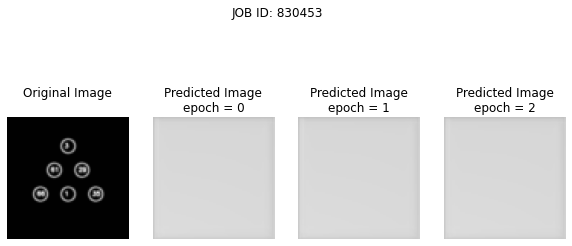

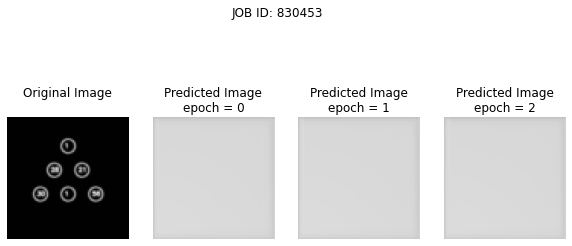

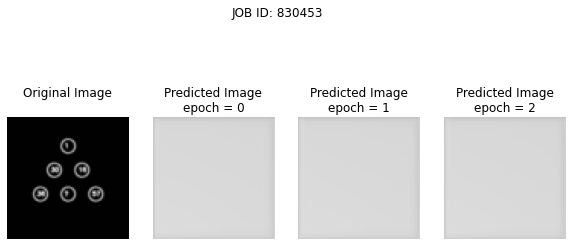

In [51]:
for img_num in range(3):
    show_predictions_during_training(
        DATA_ROOT,
        img_num=img_num,
        batch_num=0,
        epochs=None,
        job_ids=None,
        # force_gray_scale=True,
        # img_kwargs={"cmap": cm.Greys_r},
    )
    #plt.suptitle(img_num)
    plt.show()

In [52]:
def plot_slot(
    h5_file,
    batch_num,
    img_num,
    slot_id: int,
    task_name: str,
    ax,#: plt.Axes | None = None,
    force_gray_scale: bool = False,
    **kwargs,
):
    recons = np.array(h5_file[task_name]["recons"])[batch_num][img_num]
    ax = ax or plt.gca()
    ax.set_title(f"Slot {slot_id}")
    plot_image(np.transpose(recons[slot_id], (2, 0, 1)), ax, force_gray_scale, **kwargs)


def plot_slots(
    data_root,
    epoch,
    batch_num,
    img_num,
    job_id: int,
    task_name: str,
    slot_ids=None,#: list[int] | None = None,
    fig_shape=None,#: tuple[int, int] | None = None,
    force_gray_scale: bool = False,
    fig_kwargs: dict = {},

) -> None:
    x = h5py.File(os.path.join(data_root, f"{job_id}_slots_0_{epoch}.hy"))
    recons = np.array(x[task_name]["recons"])[batch_num][img_num]

    if slot_ids is None:
        slot_ids = list(range(recons.shape[0]))
        slot_ids.sort()

    if fig_shape is None:
        fig_shape = (1, len(slot_ids) + 1)
    fig, axes = plt.subplots(*fig_shape, figsize=(10, 5))

    # TODO: make it work when len(slot_ids) != fig_shape[0] * fig_shape[1] - 1
    for i, (slot, ax) in enumerate(zip(slot_ids, axes.flat[1:])):
        if i == 0:
            axes.flat[0].set_title("Reconstructed image")
            plot_image(
                np.array(x[task_name]["pred_img"])[batch_num][img_num],
                axes.flat[0],
                force_gray_scale=force_gray_scale,
                **fig_kwargs,
            )
        ax.set_title(f"Slot {slot}")
        plot_slot(
            x,
            batch_num,
            img_num,
            slot,
            task_name,
            ax,
            force_gray_scale=force_gray_scale,
            **fig_kwargs,
        )
    x.close()

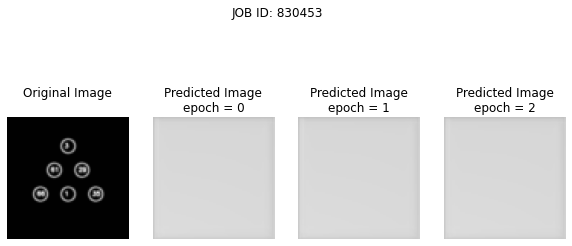

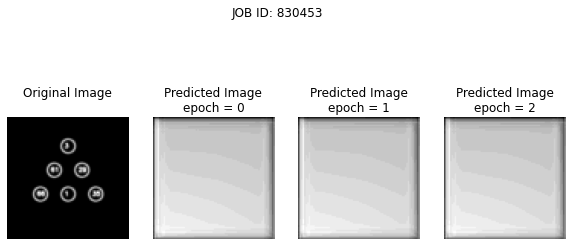

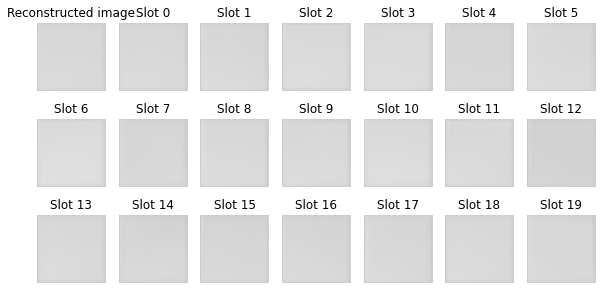

In [53]:
show_predictions_during_training(
    DATA_ROOT,
    img_num=0,
    batch_num=0,
    epochs=None,
    job_ids=None
)
show_predictions_during_training(
    DATA_ROOT,
    img_num=0,
    batch_num=0,
    epochs=None,
    job_ids=None,
    force_gray_scale=True,
    img_kwargs={"cmap": plt.get_cmap('gray')},
)

plot_slots(DATA_ROOT, epoch=0, img_num=0, batch_num=0, 
           job_id=830453,
           task_name='mns',
           fig_shape=(3, 7))
# slot_ids=[0, 1, 2, 3]